### 1. RNN KOSPI 5일치를 넣어서 1일 후 주가예측

In [23]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import RobustScaler
from torch.utils.data import DataLoader,TensorDataset
import torch
import torch.nn as nn
import torch.optim as optim

import matplotlib.pyplot as plt

In [24]:
df = pd.read_csv('./kospi.csv')

In [25]:
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2019-01-30,2183.489990,2206.199951,2177.879883,2206.199951,2206.199951,480400
1,2019-01-31,2222.879883,2222.879883,2201.219971,2204.850098,2204.850098,545200
2,2019-02-01,2211.929932,2218.780029,2201.409912,2203.459961,2203.459961,479400
3,2019-02-07,2215.770020,2215.790039,2196.770020,2203.419922,2203.419922,427800
4,2019-02-08,2192.010010,2192.479980,2171.959961,2177.050049,2177.050049,391000


In [26]:
scaler = RobustScaler()

# RNN은 정답 값을 스케일링 하고 다시 원상복구 할건데 이게 학습이 잘된다.
df[['Open','High','Low','Close','Volume']] = scaler.fit_transform(df[['Open','High','Low','Close','Volume']])
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2019-01-30,0.332186,0.418970,0.378551,0.486927,2206.199951,-0.346476
1,2019-01-31,0.588197,0.526600,0.528788,0.478158,2204.850098,-0.171483
2,2019-02-01,0.517029,0.500145,0.530011,0.469128,2203.459961,-0.349176
3,2019-02-07,0.541987,0.480852,0.500145,0.468868,2203.419922,-0.488523
4,2019-02-08,0.387561,0.330440,0.340445,0.297574,2177.050049,-0.587902


In [27]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 431 entries, 0 to 430
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       431 non-null    object 
 1   Open       431 non-null    float64
 2   High       431 non-null    float64
 3   Low        431 non-null    float64
 4   Close      431 non-null    float64
 5   Adj Close  431 non-null    float64
 6   Volume     431 non-null    float64
dtypes: float64(6), object(1)
memory usage: 23.7+ KB


In [28]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(f'{device} is available')


cuda:0 is available


In [29]:
X = df[['Open','High','Low','Volume']].values
y = df['Close'].values


In [30]:
# 별표 3만개
def seq_data(x, y, sequence_length):

  x_seq = []
  y_seq = []

  # i가 1일차부터 n일차까지 증가함. 그때 마지막 시퀀스 길이만큼은 남겨놈
  for i in range(len(x) - sequence_length):

    # 1일차에서 +시퀀스 길이까지 픽킹
    x_seq.append(x[i: i+sequence_length])

    # 시퀀스 길이 + 1을 정답값으로. # 4일차를 정답 값
    # [].append(정답값) #!! 정답값은 ;[숫자]' 이게 아니라 '숫자' 이거로 들어감.
    # 따라서 추출 다하고 난 뒤 y_seq는 [숫자, 숫자, 숫자, ....] 즉, 행벡터가 된다.
    y_seq.append(y[i+sequence_length])


                           # (추출갯수, 시퀀스 길이 , 피처)                                       # 정답을 열벡터로 줘야해서.
  return torch.FloatTensor(x_seq).to(device), torch.FloatTensor(y_seq).view([-1, 1]).to(device) # float형 tensor로 변형, gpu사용가능하게 .to(device)를 사용.


In [31]:
# 200개 데이터를 학습, 나머지를 valid로 사용할 것.
split = 200

# 5일치로 다음날(6일차) 예측
sequence_length = 5

x_seq, y_seq = seq_data(X, y, sequence_length)

x_train_seq = x_seq[:split]
y_train_seq = y_seq[:split]
x_test_seq = x_seq[split:]
y_test_seq = y_seq[split:]
print(x_train_seq.size(), y_train_seq.size())
print(x_test_seq.size(), y_test_seq.size())

torch.Size([200, 5, 4]) torch.Size([200, 1])
torch.Size([226, 5, 4]) torch.Size([226, 1])


In [32]:
train = TensorDataset(x_train_seq, y_train_seq)
test = TensorDataset(x_test_seq, y_test_seq)

batch_size = 16
train_loader = DataLoader(dataset=train, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(dataset=test, batch_size=batch_size, shuffle=False)

# X 데이터의 shape은 (200,5,4) -> (12,16,5,4)이다

In [33]:
x_seq.size(0),x_seq.size(1),x_seq.size(2)

(426, 5, 4)

In [34]:
# 피처 갯수
input_size = x_seq.size(2)

# RNN 2층
num_layers = 2

# RNN hidden cell 1개 8노드
hidden_size = 8


In [35]:
class VanillaRNN(nn.Module):

  def __init__(self, input_size, hidden_size, sequence_length, num_layers, device):
    super(VanillaRNN, self).__init__()
    self.hidden_size = hidden_size
    self.num_layers = num_layers
    self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True) # input_size는 피처개수로 맞춰준다.
    self.fc = nn.Sequential(nn.Linear(hidden_size * sequence_length, 1))

  def forward(self, x):
                      # num_layers: RNN의 레이어 수.
                      # batch_size: 입력 데이터의 배치 크기.
                      # hidden_size: 각 RNN 레이어의 hidden state 크기.
                                                                  # 모델의 파라미터는 gpu에 있는게 맞지만,
                                                                  # h0는 새로 torch.zeros로 만드는 거라서 지피유로 이동 시켜야 한다.
    h0 = torch.zeros(self.num_layers, x.size()[0], self.hidden_size).to(device)
                     # (2층, 미니배치 사이즈 16, 히든사이즈 4)
                     # h0는 셀 상태를 저장하기 위한 그릇
    # 만약,
    # num_layers = 2 (RNN의 레이어 수)
    # batch_size = 3 (배치 크기)
    # hidden_size = 4 (hidden state의 크기)
    '''
    h0는 아래 형태가 됨.   "레이어 2개고, 히든사이즈 4니까 데이터 3개에 대한 셀상태 그릇을 아래로 써라"
    h0는 마치 여러 개의 트랙을 가진 레이스에서, 각 트랙의 출발점에 배치되는 동일한 출발선과 같다.

    tensor([[[0., 0., 0., 0.],
          [0., 0., 0., 0.],
          [0., 0., 0., 0.]],

          [[0., 0., 0., 0.],
          [0., 0., 0., 0.],
          [0., 0., 0., 0.]]])
    '''


    # out: RNN의 마지막 레이어로부터 나온 output feature 를 반환한다. (batch_size, sequence_length, hidden_size)
    out, _ = self.rnn(x, h0)

                      # fc에 넣기위해 flatten하는 단계, shape[0]는 배치크기임
                      # 즉, 배치크기 x ?의 사이즈로 유지하기 위함. reshape 후는 (batch_size, sequence_length * hidden_size)
    out = out.reshape(out.shape[0], -1)
    out = self.fc(out)
    return out

model = VanillaRNN(input_size=input_size,
                   hidden_size=hidden_size,
                   sequence_length=sequence_length,
                   num_layers=num_layers,
                   device=device).to(device)

In [36]:
criterion = nn.MSELoss()

lr = 1e-3
num_epochs = 200
optimizer = optim.Adam(model.parameters(), lr=lr)


In [37]:
loss_graph = [] # 그래프 그릴 목적인 loss. 여기다가 loss를 축적 시킬 거임
n = len(train_loader)

for epoch in range(num_epochs):
  running_loss = 0.0

  for data in train_loader:

    seq, target = data # 배치 데이터.

          # (미니배치 사이즈, 시퀀스 길이, 피처갯수)
    out = model(seq)   # 모델에 넣고,
    loss = criterion(out, target) # output 가지고 loss 구하고,

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    running_loss += loss.item() # 한 배치의 loss 더해주고,

  loss_graph.append(running_loss / n) # 한 epoch에 모든 배치들에 대한 평균 loss 리스트에 담고,
  if epoch % 10 == 0:
    print('[epoch: %d] loss: %.4f'%(epoch, running_loss/n))

[epoch: 0] loss: 0.3122
[epoch: 10] loss: 0.0452
[epoch: 20] loss: 0.0351
[epoch: 30] loss: 0.0293
[epoch: 40] loss: 0.0252
[epoch: 50] loss: 0.0224
[epoch: 60] loss: 0.0207
[epoch: 70] loss: 0.0193
[epoch: 80] loss: 0.0181
[epoch: 90] loss: 0.0170
[epoch: 100] loss: 0.0160
[epoch: 110] loss: 0.0151
[epoch: 120] loss: 0.0145
[epoch: 130] loss: 0.0139
[epoch: 140] loss: 0.0135
[epoch: 150] loss: 0.0132
[epoch: 160] loss: 0.0129
[epoch: 170] loss: 0.0126
[epoch: 180] loss: 0.0123
[epoch: 190] loss: 0.0125


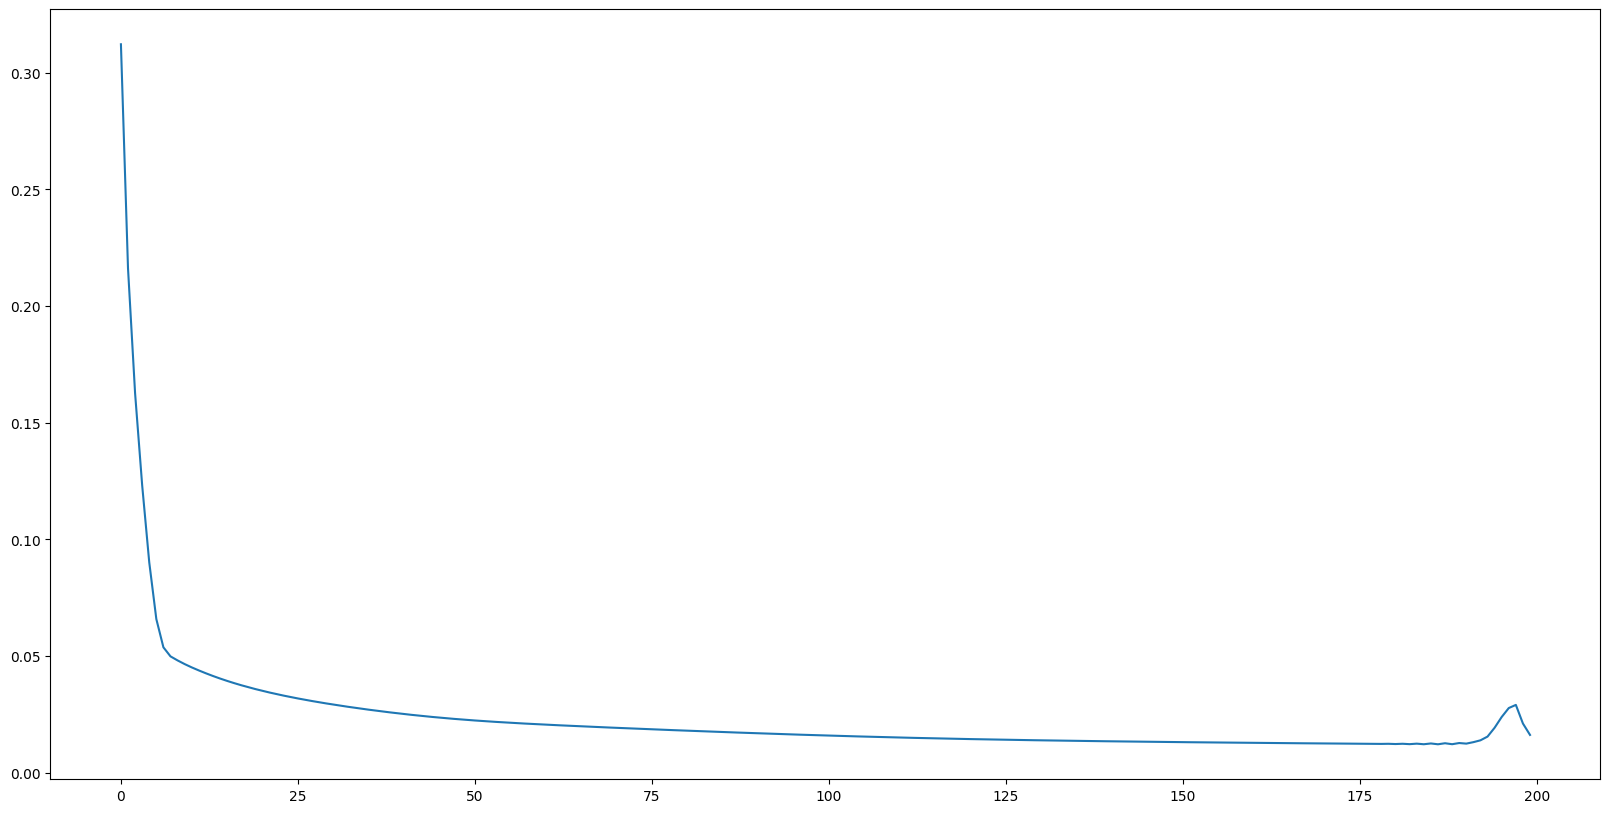

In [38]:
plt.figure(figsize=(20,10))
plt.plot(loss_graph)
plt.show()

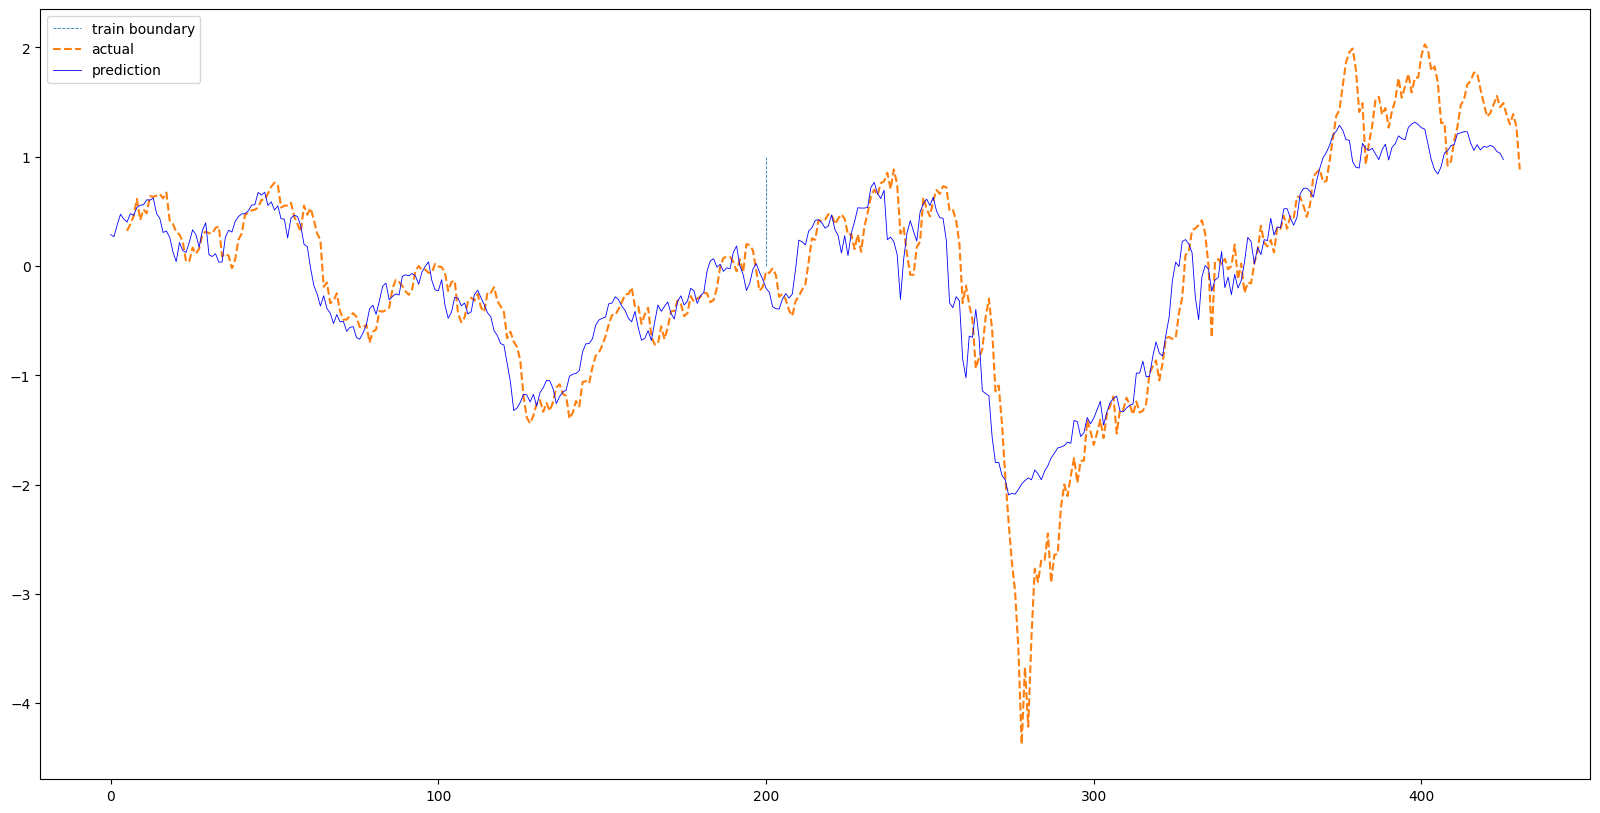

In [39]:
with torch.no_grad():
  train_pred = []
  test_pred = []

  for data in train_loader:
    seq, target = data
    out = model(seq)

    # out 결과값을 계속 concatenate 시킨다.
    train_pred += out.cpu().numpy().tolist()

  for data in test_loader:
    seq, target = data
    out = model(seq)

    # out 결과값을 계속 concatenate 시킨다.
    test_pred += out.cpu().numpy().tolist()

# 두개 이어 붙이기
total = train_pred + test_pred
plt.figure(figsize=(20,10))

# train과 test의 경계
plt.plot(np.ones(100)*len(train_pred), np.linspace(0,1,100), '--', linewidth=0.6)
#실제 주가 데이터를 표시
plt.plot(df['Close'][sequence_length:], '--')
#모델이 예측한 주가 데이터
plt.plot(total, 'b', linewidth=0.6)

plt.legend(['train boundary', 'actual', 'prediction'])
plt.show()

# 그래프가 이상하게 나올경우엔 seq_size를 더 늘려보자 예를들어 5일치로 학습을 하면 10일치로 학습시킨다거나

### 실습) 아래 IM뱅크의 주가 데이터를 준비해 놓았다.

위 코드를 참고하여 RNN 학습 및 시각화를 해보자. 5일치로 1일 후 예측

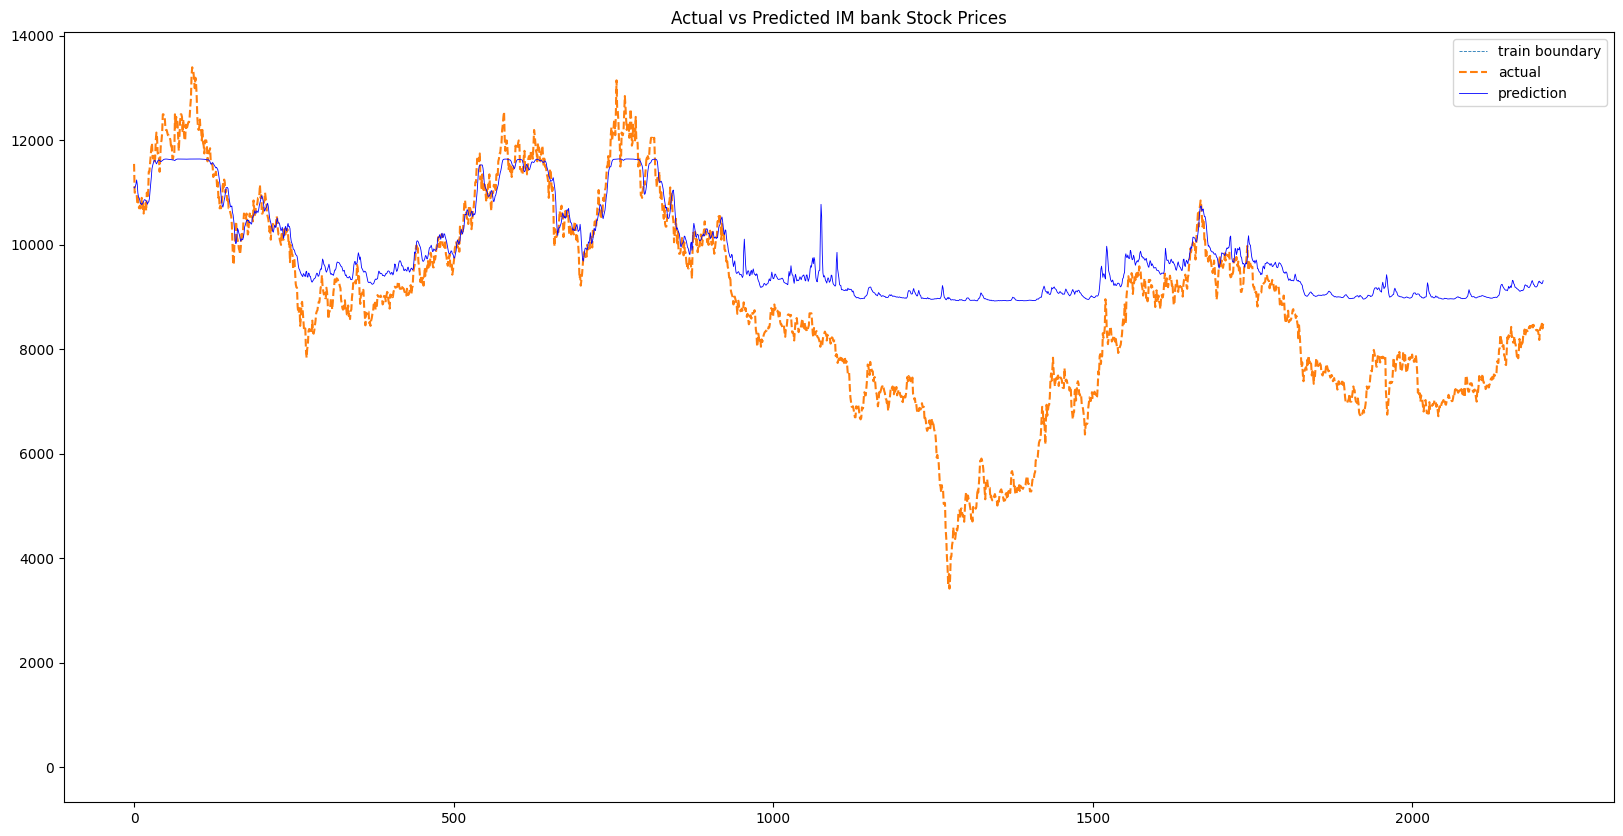

In [40]:
!pip install yfinance

In [13]:
import yfinance as yf
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import RobustScaler
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from torch.utils.data import TensorDataset, DataLoader

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 대구은행 주식 데이터
ticker = "139130.KS"
df = yf.download(ticker, start="2015-01-01", end="2024-01-01")

df = df.reset_index()


scaler = RobustScaler()

# RNN은 정답 값을 스케일링 하고 다시 원상복구 할건데 이게 학습이 잘된다.
df[['Open','High','Low','Close','Volume']] = scaler.fit_transform(df[['Open','High','Low','Close','Volume']])
print(df.head())


X = df[['Open', 'High', 'Low', 'Volume']].values
y = df['Close'].values

[*********************100%***********************]  1 of 1 completed

        Date      Open      High       Low     Close    Adj Close    Volume
0 2015-01-02  0.886861  0.836879  0.870849  0.835766  7079.585938 -0.453246
1 2015-01-05  0.813869  0.783688  0.760148  0.726277  6889.954102  0.043595
2 2015-01-06  0.686131  0.641844  0.667897  0.616788  6700.322266  0.345018
3 2015-01-07  0.594891  0.588652  0.557196  0.635036  6731.927734  2.187955
4 2015-01-08  0.667883  0.819149  0.704797  0.854015  7111.191895  0.832245


In [14]:
df.shape

(2211, 7)

In [15]:
# 별표 3만개
def seq_data(x, y, sequence_length):

  x_seq = []
  y_seq = []

  # i가 1일차부터 n일차까지 증가함. 그때 마지막 시퀀스 길이만큼은 남겨놈
  for i in range(len(x) - sequence_length):

    # 1일차에서 +시퀀스 길이까지 픽킹
    x_seq.append(x[i: i+sequence_length])

    # 시퀀스 길이 + 1을 정답값으로. # 4일차를 정답 값
    # [].append(정답값) #!! 정답값은 ;[숫자]' 이게 아니라 '숫자' 이거로 들어감.
    # 따라서 추출 다하고 난 뒤 y_seq는 [숫자, 숫자, 숫자, ....] 즉, 행벡터가 된다.
    y_seq.append(y[i+sequence_length])


                           # (추출갯수, 시퀀스 길이 , 피처)                                       # 정답을 열벡터로 줘야해서.
  return torch.FloatTensor(x_seq).to(device), torch.FloatTensor(y_seq).view([-1, 1]).to(device) # float형 tensor로 변형, gpu사용가능하게 .to(device)를 사용.


In [16]:
# 200개 데이터를 학습, 나머지를 valid로 사용할 것.
split = 1000

# 5일치로 다음날(6일차) 예측
sequence_length = 5

x_seq, y_seq = seq_data(X, y, sequence_length)

x_train_seq = x_seq[:split]
y_train_seq = y_seq[:split]
x_test_seq = x_seq[split:]
y_test_seq = y_seq[split:]
print(x_train_seq.size(), y_train_seq.size())
print(x_test_seq.size(), y_test_seq.size())

torch.Size([1000, 5, 4]) torch.Size([1000, 1])
torch.Size([1206, 5, 4]) torch.Size([1206, 1])


In [17]:
train = TensorDataset(x_train_seq, y_train_seq)
test = TensorDataset(x_test_seq, y_test_seq)

batch_size = 16
train_loader = DataLoader(dataset=train, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(dataset=test, batch_size=batch_size, shuffle=False)

# X 데이터의 shape은 (1000,5,4) -> ( 계산해봐야함 ,16,5,4)이다

In [18]:
# 피처 갯수
input_size = x_seq.size(2)

# RNN 2층
num_layers = 2

# RNN hidden cell 1개 8노드
hidden_size = 8

x_seq.size(0),x_seq.size(1),x_seq.size(2)

(2206, 5, 4)

In [19]:
class VanillaRNN(nn.Module):

  def __init__(self, input_size, hidden_size, sequence_length, num_layers, device):
    super(VanillaRNN, self).__init__()
    self.hidden_size = hidden_size
    self.num_layers = num_layers
    self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True) # input_size는 피처개수로 맞춰준다.
    self.fc = nn.Sequential(nn.Linear(hidden_size * sequence_length, 1))

  def forward(self, x):
                      # num_layers: RNN의 레이어 수.
                      # batch_size: 입력 데이터의 배치 크기.
                      # hidden_size: 각 RNN 레이어의 hidden state 크기.
                                                                  # 모델의 파라미터는 gpu에 있는게 맞지만,
                                                                  # h0는 새로 torch.zeros로 만드는 거라서 지피유로 이동 시켜야 한다.
    h0 = torch.zeros(self.num_layers, x.size()[0], self.hidden_size).to(device)
                     # (2층, 미니배치 사이즈 16, 히든사이즈 4)
                     # h0는 셀 상태를 저장하기 위한 그릇
    # 만약,
    # num_layers = 2 (RNN의 레이어 수)
    # batch_size = 3 (배치 크기)
    # hidden_size = 4 (hidden state의 크기)
    '''
    h0는 아래 형태가 됨.   "레이어 2개고, 히든사이즈 4니까 데이터 3개에 대한 셀상태 그릇을 아래로 써라"
    h0는 마치 여러 개의 트랙을 가진 레이스에서, 각 트랙의 출발점에 배치되는 동일한 출발선과 같다.

    tensor([[[0., 0., 0., 0.],
          [0., 0., 0., 0.],
          [0., 0., 0., 0.]],

          [[0., 0., 0., 0.],
          [0., 0., 0., 0.],
          [0., 0., 0., 0.]]])
    '''


    # out: RNN의 마지막 레이어로부터 나온 output feature 를 반환한다. (batch_size, sequence_length, hidden_size)
    out, _ = self.rnn(x, h0)

                      # fc에 넣기위해 flatten하는 단계, shape[0]는 배치크기임
                      # 즉, 배치크기 x ?의 사이즈로 유지하기 위함. reshape 후는 (batch_size, sequence_length * hidden_size)
    out = out.reshape(out.shape[0], -1)
    out = self.fc(out)
    return out

model = VanillaRNN(input_size=input_size,
                   hidden_size=hidden_size,
                   sequence_length=sequence_length,
                   num_layers=num_layers,
                   device=device).to(device)

In [20]:
criterion = nn.MSELoss()

lr = 1e-3
num_epochs = 200
optimizer = optim.Adam(model.parameters(), lr=lr)

loss_graph = [] # 그래프 그릴 목적인 loss. 여기다가 loss를 축적 시킬 거임
n = len(train_loader)

for epoch in range(num_epochs):
  running_loss = 0.0

  for data in train_loader:

    seq, target = data # 배치 데이터.

          # (미니배치 사이즈, 시퀀스 길이, 피처갯수)
    out = model(seq)   # 모델에 넣고,
    loss = criterion(out, target) # output 가지고 loss 구하고,

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    running_loss += loss.item() # 한 배치의 loss 더해주고,

  loss_graph.append(running_loss / n) # 한 epoch에 모든 배치들에 대한 평균 loss 리스트에 담고,
  if epoch % 10 == 0:
    print('[epoch: %d] loss: %.4f'%(epoch, running_loss/n))

[epoch: 0] loss: 0.4755
[epoch: 10] loss: 0.0142
[epoch: 20] loss: 0.0112
[epoch: 30] loss: 0.0091
[epoch: 40] loss: 0.0075
[epoch: 50] loss: 0.0064
[epoch: 60] loss: 0.0057
[epoch: 70] loss: 0.0053
[epoch: 80] loss: 0.0052
[epoch: 90] loss: 0.0051
[epoch: 100] loss: 0.0050
[epoch: 110] loss: 0.0050
[epoch: 120] loss: 0.0049
[epoch: 130] loss: 0.0049
[epoch: 140] loss: 0.0049
[epoch: 150] loss: 0.0048
[epoch: 160] loss: 0.0048
[epoch: 170] loss: 0.0048
[epoch: 180] loss: 0.0048
[epoch: 190] loss: 0.0048


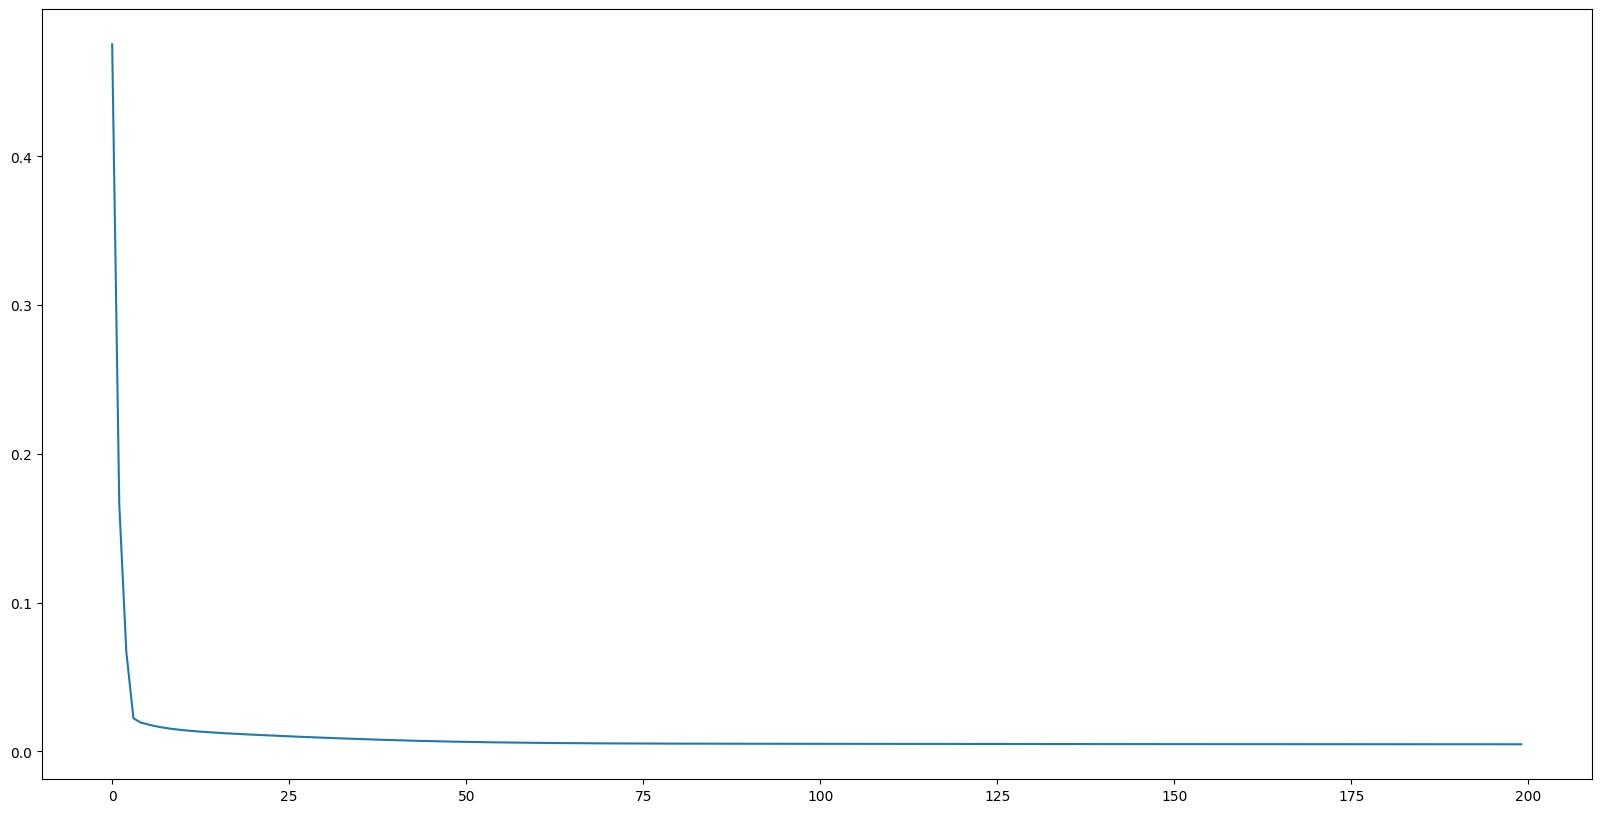

In [21]:
plt.figure(figsize=(20,10))
plt.plot(loss_graph)
plt.show()

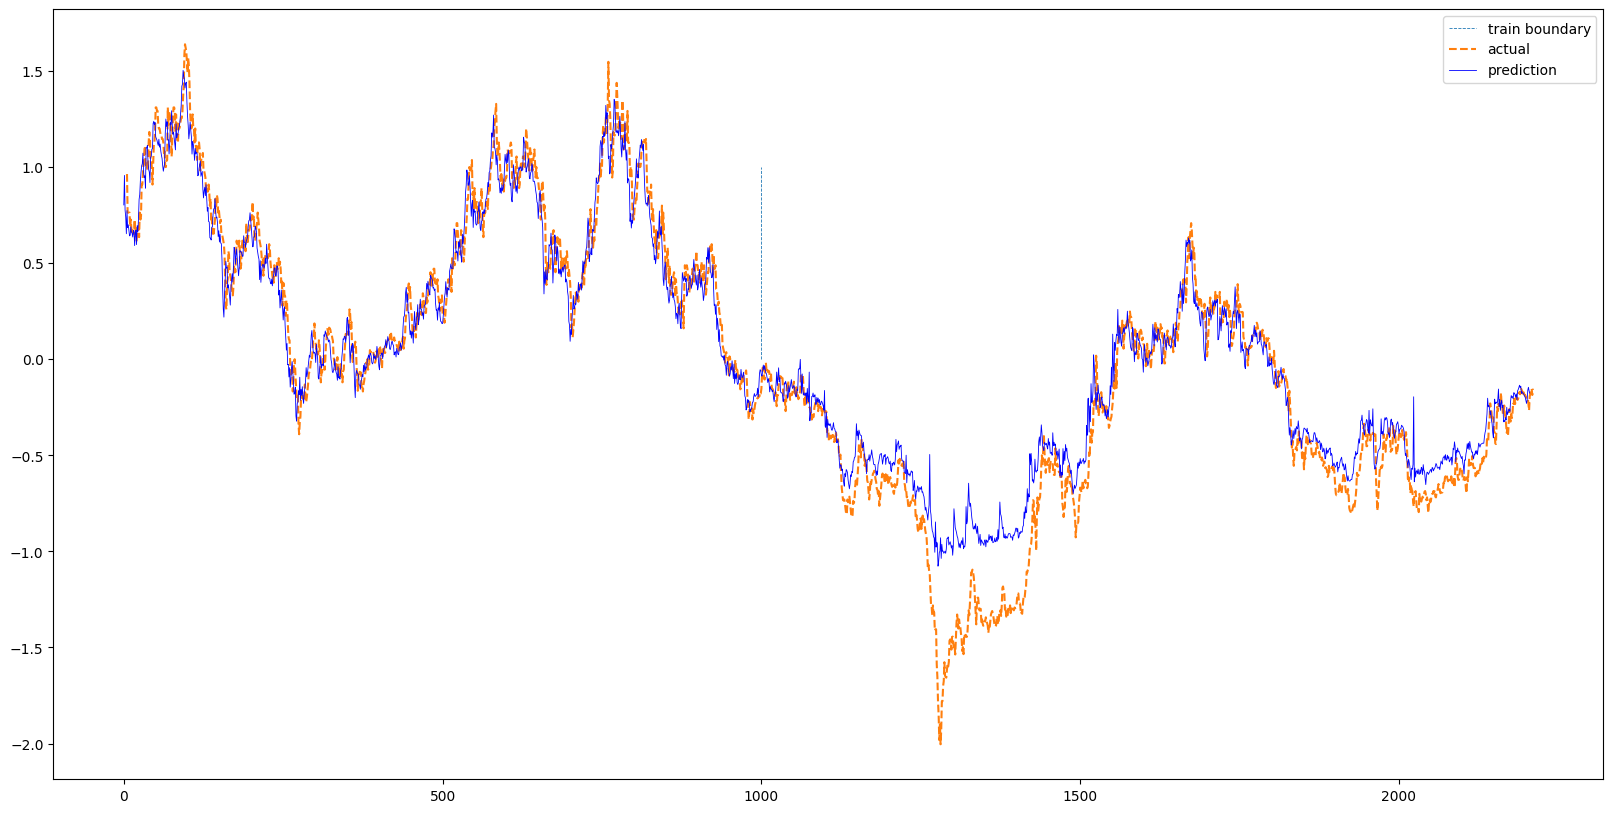

In [22]:
with torch.no_grad():
  train_pred = []
  test_pred = []

  for data in train_loader:
    seq, target = data
    out = model(seq)

    # out 결과값을 계속 concatenate 시킨다.
    train_pred += out.cpu().numpy().tolist()

  for data in test_loader:
    seq, target = data
    out = model(seq)

    # out 결과값을 계속 concatenate 시킨다.
    test_pred += out.cpu().numpy().tolist()

# 두개 이어 붙이기
total = train_pred + test_pred
plt.figure(figsize=(20,10))

# train과 test의 경계
plt.plot(np.ones(100)*len(train_pred), np.linspace(0,1,100), '--', linewidth=0.6)
#실제 주가 데이터를 표시
plt.plot(df['Close'][sequence_length:], '--')
#모델이 예측한 주가 데이터
plt.plot(total, 'b', linewidth=0.6)

plt.legend(['train boundary', 'actual', 'prediction'])
plt.show()

# 그래프가 이상하게 나올경우엔 seq_size를 더 늘려보자 예를들어 5일치로 학습을 하면 10일치로 학습시킨다거나

### 실습) "서울시_기간별_시간평균_대기환경_정보_2020.csv" 파일을 이용해서 '미세먼지 1시간(㎍/㎥)'를 예측하자. 데이터는 준비되어 있다.

모델 성능은 아래 그래프정도만 나와도 훌륭하다.

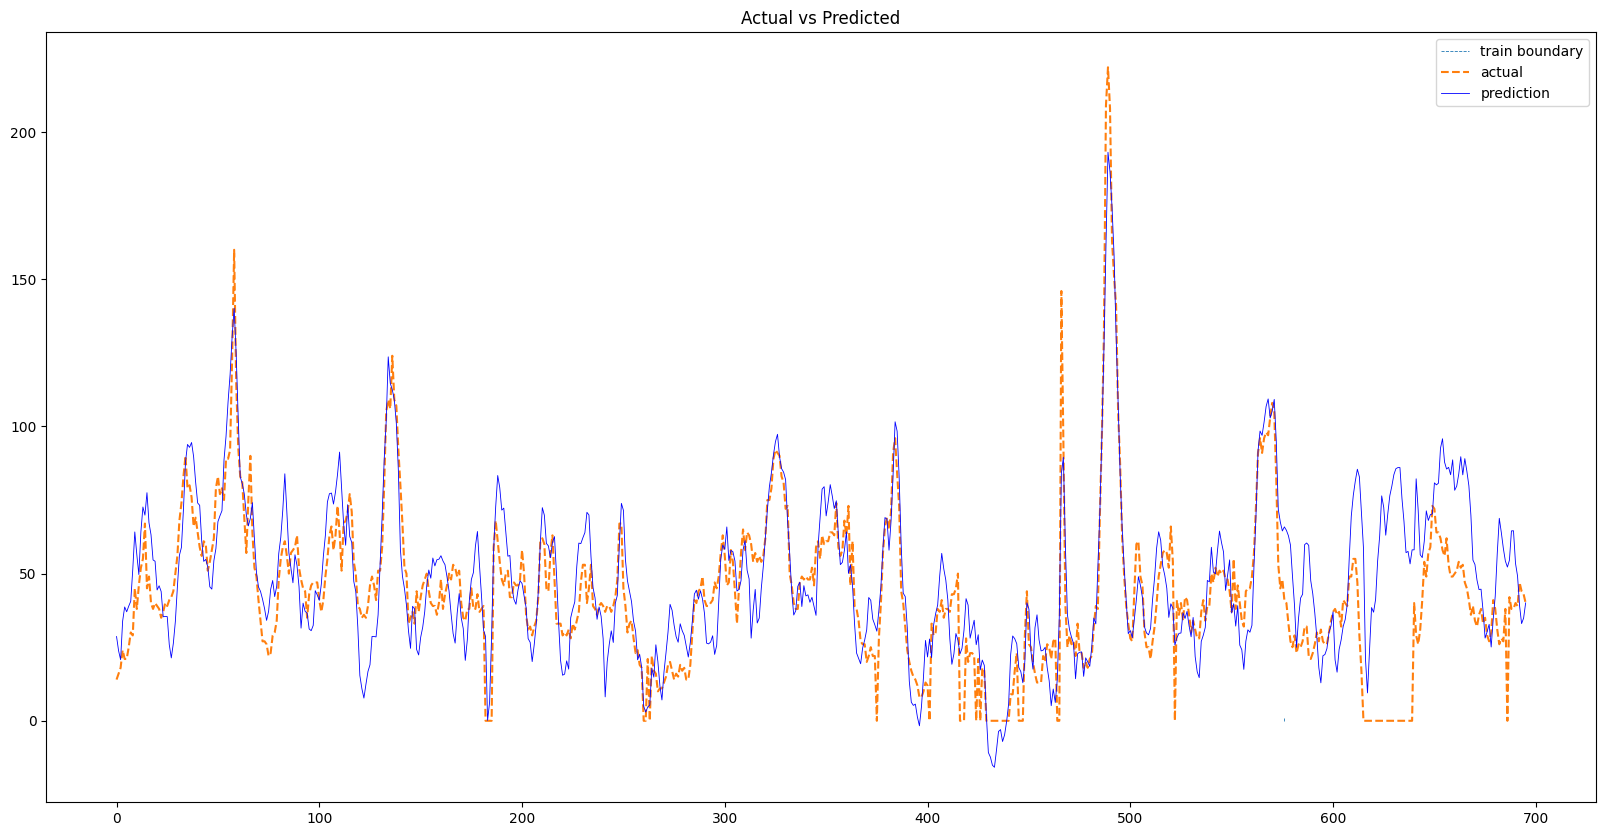

In [41]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import RobustScaler
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

file_path = '서울시_기간별_시간평균_대기환경_정보_2020.04.csv'

                            # 인코딩이 깨지기 때문에 cp949 인코딩을 명시
df = pd.read_csv(file_path, encoding="cp949")

# '측정일시'를 datetime 형식으로 변환
df['측정일시'] = pd.to_datetime(df['측정일시'], format='%Y%m%d%H%M')

# 날짜가 거꾸로 되어있어서 '측정일시' 오름차순 정렬 (왜냐하면 미래를 예측할거니까)
df = df.sort_values(by='측정일시').reset_index(drop=True)

display(df)


,측정일시,권역코드,권역명,측정소코드,측정소명,미세먼지 1시간(㎍/㎥),미세먼지 24시간(㎍/㎥),초미세먼지(㎍/㎥),오존(ppm),이산화질소농도(ppm),일산화탄소농도(ppm),아황산가스농도(ppm)
0,2020-04-01 00:00:00,104,동남권,111262,서초구,55,52,22,0.036,0.027,0.3,0.004
1,2020-04-01 00:00:00,100,도심권,111131,용산구,58,53,23,0.021,0.035,0.6,0.003
2,2020-04-01 00:00:00,100,도심권,111123,종로구,46,47,23,0.033,0.019,0.5,0.003
3,2020-04-01 00:00:00,100,도심권,111121,중구,44,44,24,0.032,0.020,0.4,0.003
4,2020-04-01 00:00:00,101,서북권,111201,마포구,48,43,23,0.014,0.043,0.6,0.003
...,...,...,...,...,...,...,...,...,...,...,...,...
17995,2020-04-30 23:00:00,104,동남권,111261,강남구,32,34,23,0.046,0.008,0.4,0.002
17996,2020-04-30 23:00:00,104,동남권,111274,강동구,43,39,24,0.037,0.009,0.4,0.002
17997,2020-04-30 23:00:00,104,동남권,111262,서초구,40,42,28,0.057,0.006,0.2,0.002
17998,2020-04-30 23:00:00,102,동북권,111171,도봉구,35,36,21,0.048,0.010,0.3,0.003


In [42]:
df['측정소명'].value_counts()

,count
측정소명,
서초구,720
동대문구,720
노원구,720
영등포구,720
금천구,720
관악구,720
도봉구,720
강서구,720
동작구,720


In [43]:
# 서초구만 쓰자.
df = df.loc[df['측정소명']=="서초구"]
display(df)

,측정일시,권역코드,권역명,측정소코드,측정소명,미세먼지 1시간(㎍/㎥),미세먼지 24시간(㎍/㎥),초미세먼지(㎍/㎥),오존(ppm),이산화질소농도(ppm),일산화탄소농도(ppm),아황산가스농도(ppm)
0,2020-04-01 00:00:00,104,동남권,111262,서초구,55,52,22,0.036,0.027,0.3,0.004
39,2020-04-01 01:00:00,104,동남권,111262,서초구,59,54,26,0.028,0.035,0.3,0.004
65,2020-04-01 02:00:00,104,동남권,111262,서초구,68,57,31,0.033,0.027,0.4,0.004
89,2020-04-01 03:00:00,104,동남권,111262,서초구,74,58,32,0.038,0.021,0.4,0.004
114,2020-04-01 04:00:00,104,동남권,111262,서초구,83,59,36,0.043,0.018,0.4,0.004
...,...,...,...,...,...,...,...,...,...,...,...,...
17889,2020-04-30 19:00:00,104,동남권,111262,서초구,39,37,26,0.059,0.011,0.3,0.002
17916,2020-04-30 20:00:00,104,동남권,111262,서초구,47,38,26,0.054,0.010,0.3,0.002
17946,2020-04-30 21:00:00,104,동남권,111262,서초구,44,40,28,0.056,0.006,0.2,0.002
17968,2020-04-30 22:00:00,104,동남권,111262,서초구,43,41,25,0.055,0.007,0.2,0.002


{'whiskers': [<matplotlib.lines.Line2D at 0x7cfb6c662590>,
 'caps': [<matplotlib.lines.Line2D at 0x7cfb6c662ad0>,
 'boxes': [<matplotlib.lines.Line2D at 0x7cfb6c6622f0>],
 'medians': [<matplotlib.lines.Line2D at 0x7cfb6c663010>],
 'fliers': [<matplotlib.lines.Line2D at 0x7cfb6c6632b0>],
 'means': []}

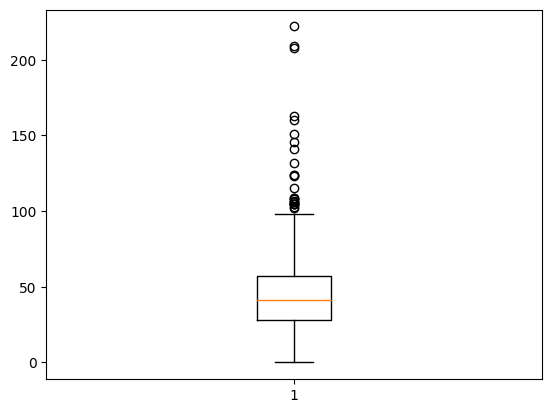

In [44]:
plt.boxplot(df['미세먼지 1시간(㎍/㎥)'])

In [45]:
df = df[['미세먼지 1시간(㎍/㎥)', '초미세먼지(㎍/㎥)', '오존(ppm)', '이산화질소농도(ppm)', '일산화탄소농도(ppm)', '아황산가스농도(ppm)']]
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 720 entries, 0 to 17997
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   미세먼지 1시간(㎍/㎥)  720 non-null    int64  
 1   초미세먼지(㎍/㎥)     720 non-null    int64  
 2   오존(ppm)        720 non-null    float64
 3   이산화질소농도(ppm)   720 non-null    float64
 4   일산화탄소농도(ppm)   720 non-null    float64
 5   아황산가스농도(ppm)   720 non-null    float64
dtypes: float64(4), int64(2)
memory usage: 39.4 KB


In [46]:
X = df[['초미세먼지(㎍/㎥)', '오존(ppm)', '이산화질소농도(ppm)', '일산화탄소농도(ppm)', '아황산가스농도(ppm)']].values
y = df['미세먼지 1시간(㎍/㎥)'].values

[epoch: 0] loss: 1.0259
[epoch: 10] loss: 0.6617
[epoch: 20] loss: 0.6126
[epoch: 30] loss: 0.5812
[epoch: 40] loss: 0.5118
[epoch: 50] loss: 0.4095
[epoch: 60] loss: 0.3794
[epoch: 70] loss: 0.2794
[epoch: 80] loss: 0.2228
[epoch: 90] loss: 0.2755


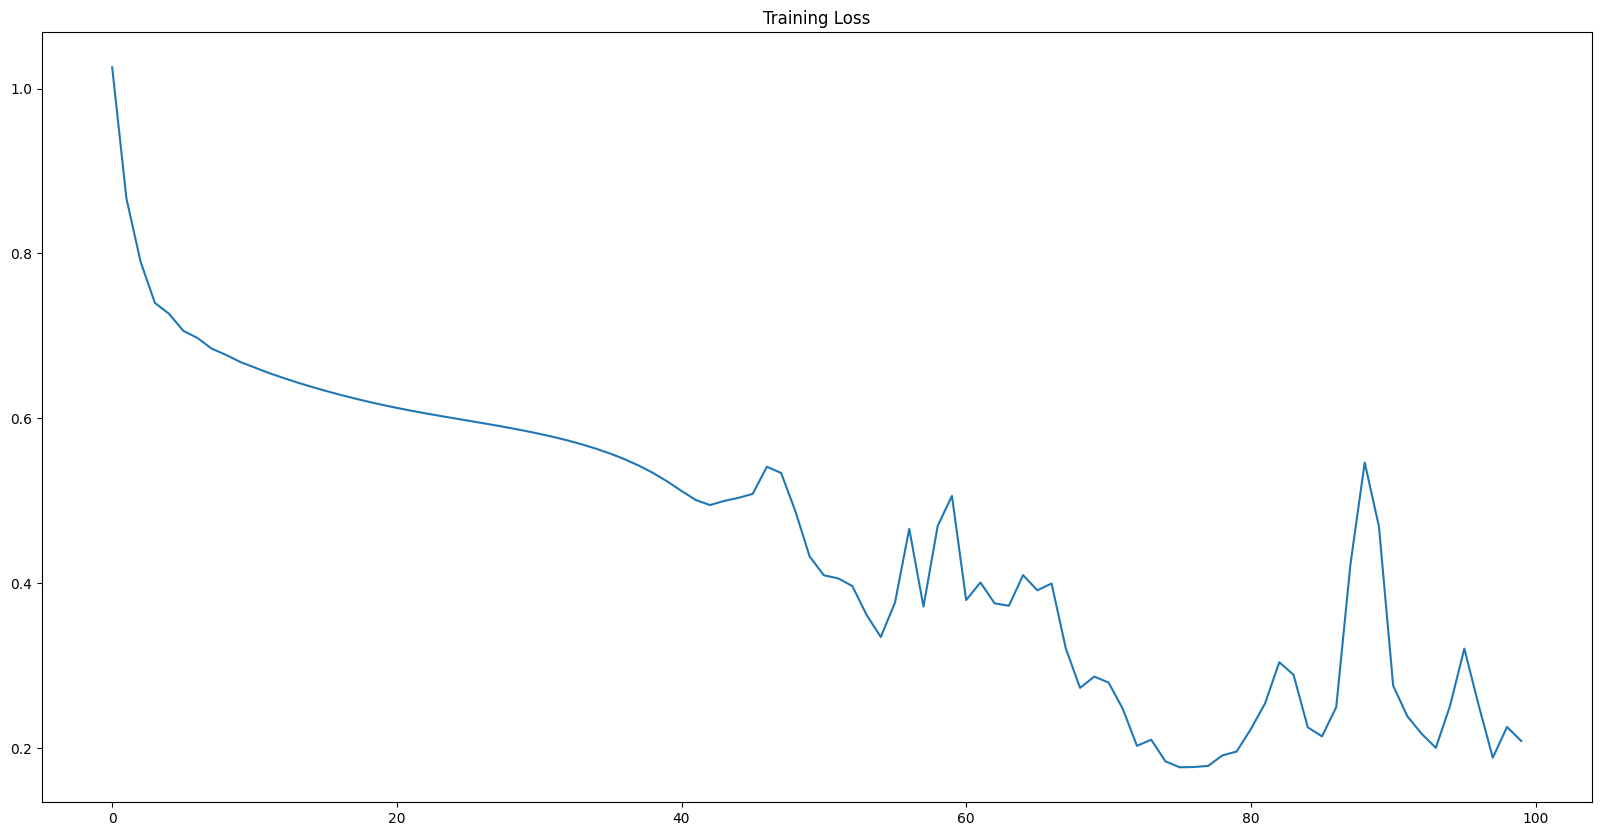

In [48]:
import yfinance as yf
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import RobustScaler
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from torch.utils.data import TensorDataset, DataLoader

scaler_X = RobustScaler()
scaler_y = RobustScaler()

X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y.reshape(-1, 1))

# 시퀀스 데이터
def seq_data(x, y, sequence_length):
    x_seq = []
    y_seq = []
    for i in range(len(x) - sequence_length):
        x_seq.append(x[i: i+sequence_length])
        y_seq.append(y[i+sequence_length])
    return torch.FloatTensor(x_seq).to(device), torch.FloatTensor(y_seq).view([-1, 1]).to(device)

sequence_length = 24 # 하루(24시간) 단위로 시퀀스 길이 설정


x_seq, y_seq = seq_data(X_scaled, y_scaled, sequence_length)
split = int(len(df) * 0.8)         # 훈련 및 테스트 데이터 8 : 2로 분할
x_train_seq = x_seq[:split]
y_train_seq = y_seq[:split]
x_test_seq = x_seq[split:]
y_test_seq = y_seq[split:]

train = TensorDataset(x_train_seq, y_train_seq)
test = TensorDataset(x_test_seq, y_test_seq)

batch_size = 32
train_loader = DataLoader(dataset=train, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(dataset=test, batch_size=batch_size, shuffle=False)



class VanillaRNN(nn.Module):
    def __init__(self, input_size, hidden_size, sequence_length, num_layers):
        super(VanillaRNN, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)

        self.fc = nn.Sequential(
            nn.Linear(hidden_size * sequence_length, 1)
        )

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size()[0], self.hidden_size).to(device)
        out, _ = self.rnn(x, h0)
        out = out.reshape(out.shape[0], -1)
        out = self.fc(out)
        return out

input_size = x_seq.size(2)
num_layers = 2
hidden_size = 50    #

model = VanillaRNN(input_size=input_size,
                   hidden_size=hidden_size,
                   sequence_length=sequence_length,
                   num_layers=num_layers,
                  ).to(device)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

num_epochs = 100    #
loss_graph = []

for epoch in range(num_epochs):
    running_loss = 0.0
    for data in train_loader:
        seq, target = data
        out = model(seq)
        loss = criterion(out, target)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    loss_graph.append(running_loss / len(train_loader))
    if epoch % 10 == 0:
        print(f'[epoch: {epoch}] loss: {running_loss / len(train_loader):.4f}')

# 손실 시각화
plt.figure(figsize=(20,10))
plt.plot(loss_graph)
plt.title('Training Loss')
plt.show()

/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 48120 (\N{HANGUL SYLLABLE MI}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 49464 (\N{HANGUL SYLLABLE SE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 47676 (\N{HANGUL SYLLABLE MEON}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 51648 (\N{HANGUL SYLLABLE JI}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 49884 (\N{HANGUL SYLLABLE SI}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPy

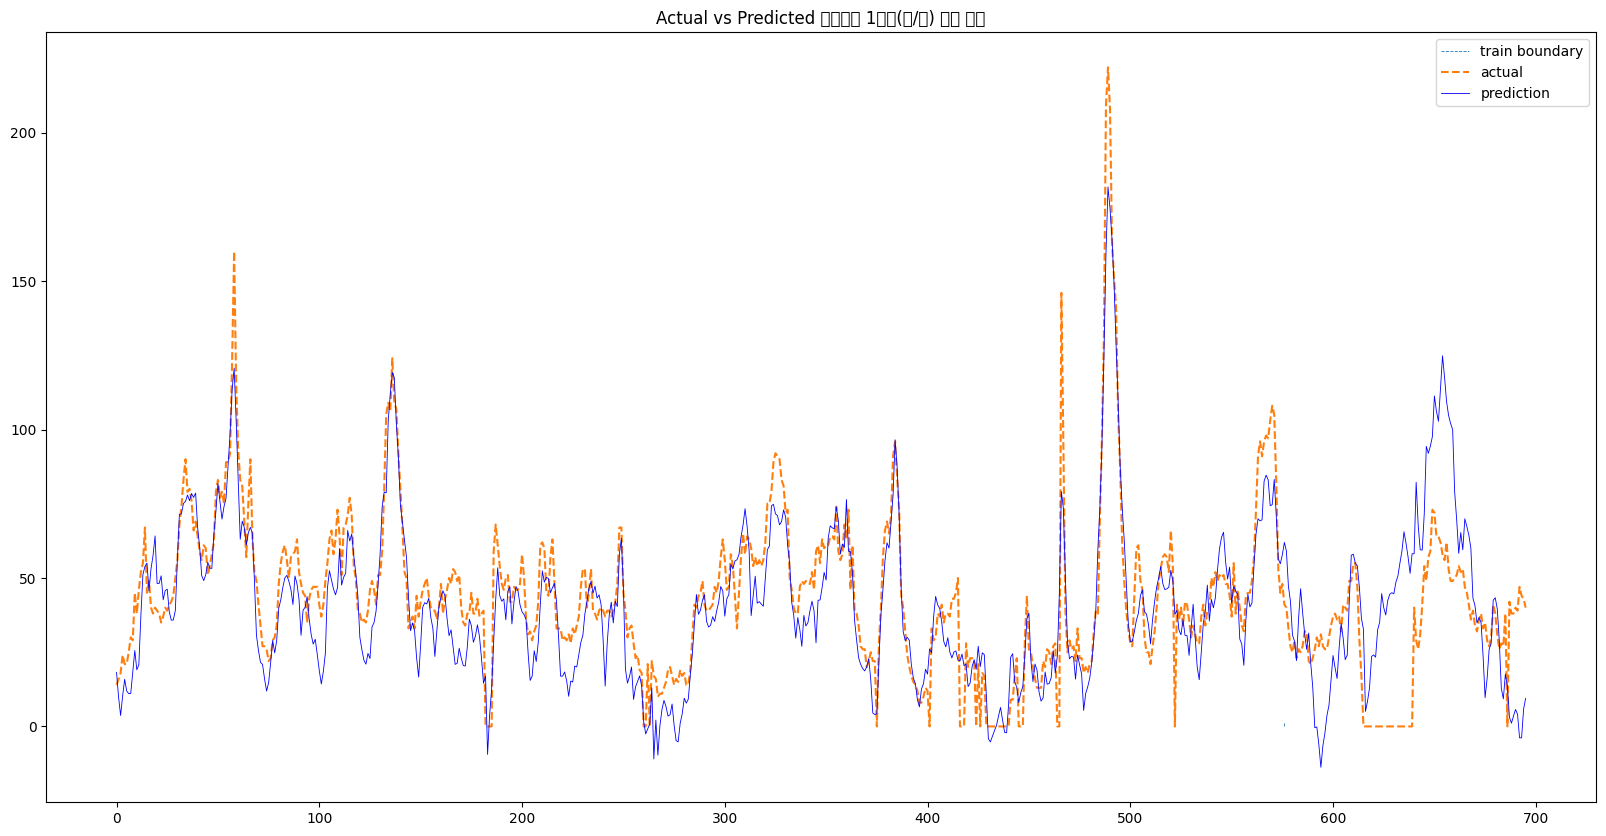

In [49]:
actual = df['미세먼지 1시간(㎍/㎥)'][sequence_length:]


model.eval()
with torch.no_grad():
    train_pred = []
    test_pred = []

    for data in train_loader:
        seq, target = data
        out = model(seq)
        train_pred += out.cpu().numpy().tolist()

    for data in test_loader:
        seq, target = data
        out = model(seq)
        test_pred += out.cpu().numpy().tolist()

total = train_pred + test_pred
total_inverse = scaler_y.inverse_transform(total)

plt.figure(figsize=(20,10))
plt.plot(np.ones(100)*len(train_pred), np.linspace(0,1,100), '--', linewidth=0.6)
plt.plot(df['미세먼지 1시간(㎍/㎥)'][sequence_length:].values, '--')
plt.plot(total_inverse, 'b', linewidth=0.6)
plt.title('Actual vs Predicted 미세먼지 1시간(㎍/㎥) 농도 예측')
plt.legend(['train boundary', 'actual', 'prediction'])
plt.show()

### 2. LSTM 삼성전자 주가 200 시퀀스로 30일치 예측

[*********************100%***********************]  1 of 1 completed


Epoch [10/100], Loss: 0.0511
Epoch [20/100], Loss: 0.0443
Epoch [30/100], Loss: 0.0404
Epoch [40/100], Loss: 0.0355
Epoch [50/100], Loss: 0.0326
Epoch [60/100], Loss: 0.0304
Epoch [70/100], Loss: 0.0276
Epoch [80/100], Loss: 0.0243
Epoch [90/100], Loss: 0.0231
Epoch [100/100], Loss: 0.0223


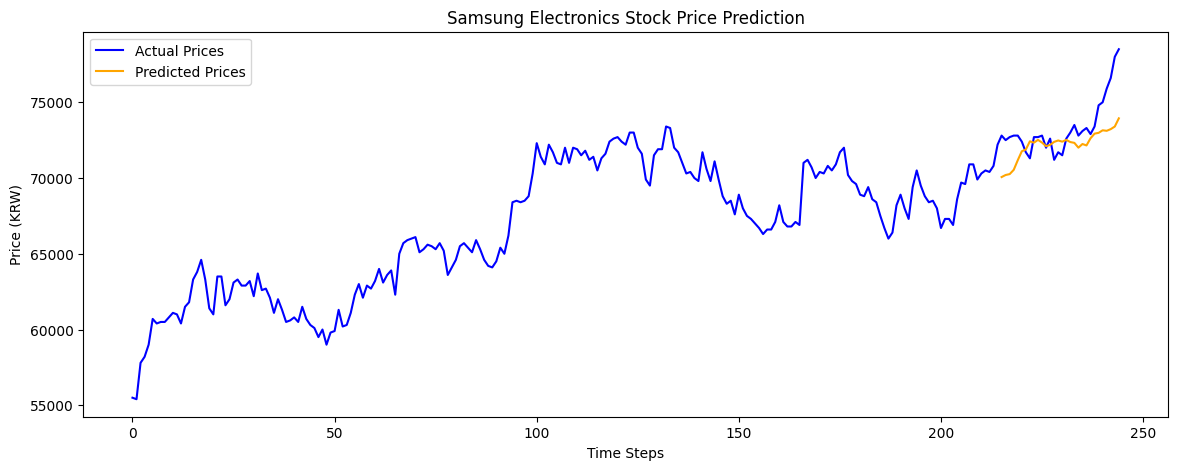

In [1]:
# 200일치 데이터로 30일치 예측.

import yfinance as yf
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import StandardScaler
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt

# GPU 설정
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

ticker = "005930.KS"  # 삼성전자 주식 코드
df = yf.download(ticker, start="2023-01-01", end="2023-12-31")

# 입력 특성 (Open, High, Low, Volume) 및 타겟 (Close) 설정
X = df[['Open', 'High', 'Low', 'Volume']].values
y = df['Close'].values

# 데이터 정규화
scaler_X = StandardScaler()
scaler_y = StandardScaler()

X_normalized = scaler_X.fit_transform(X)
                                      # 정답값 열벡터로 줄 것이다
y_normalized = scaler_y.fit_transform(y.reshape(-1, 1))

# 시퀀스 데이터 생성 함수
def create_sequences(data_X, data_y, seq_length, predict_length):
    xs, ys = [], []
                 # 전체 데이터 길이 - 시퀀스 길이 - 예측 길이
    for i in range(len(data_X) - seq_length - predict_length):
        # 시퀀스 길이만큼 추출
        x = data_X[i:i+seq_length]

        # 예를들어 1,2,3,4,5 일치 데이터로 6,7,8일치 예측을 한다면.
        # 1일치 + 5일치 => 6일치, 7일, 8일

        # 만약 seq_lenth가 5이면
                # , 인덱스 5번 ~ 인데스 + 3 => 인덱스 8 => 인덱스 5,6,7 지정
        # i = 0 , seq_length = 5, 예측길이가 3일 때,
        # 0 + 5 : 0 + 5 + 3 => 5:8 => 5,6,7 인덱스가 슬라이싱 => 즉,6일치 7일치 8일치

        # 현재 삼성전자 주가 200일치로 30일치를 예측,

        # i = 0 ,seq_length = 200, predict_length =30
        # 0 + 200 : 0 + 200 + 300 => 200: 230 => 201일부터 230일까지 정답값으로 씀
        y = data_y[i+seq_length:i+seq_length+predict_length]
        xs.append(x)
        ys.append(y)

        # 반환되는 값 xs는 (추출된 갯수, 시퀀스 길이 , 피처)
        # ys는 (추출된 갯수,1, 예측길이)
    return np.array(xs), np.array(ys)

seq_length = 200  # 입력 시퀀스 길이 200일치.
predict_length = 30  # 예측할 일수 30일 예측.
X_seq, y_seq = create_sequences(X_normalized, y_normalized, seq_length, predict_length)

# numpy array -> torch tensor
X_seq = torch.FloatTensor(X_seq)
y_seq = torch.FloatTensor(y_seq).squeeze(-1)

# 데이터셋 및 데이터로더 생성
split = int(len(X_seq) * 0.8)
train_X, test_X = X_seq[:split], X_seq[split:]
train_y, test_y = y_seq[:split], y_seq[split:]

train_dataset = TensorDataset(train_X, train_y)
test_dataset = TensorDataset(test_X, test_y)

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# LSTM 모델 정의
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, predict_length):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.predict_length = predict_length
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, predict_length)

    def forward(self, x):
        # LSTM은 h0 : hidden state와 c0 : cell을 미리 준비해야한다.
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)

        out, _ = self.lstm(x, (h0, c0))
                                    # out이 [32: -1: 30]
        out = self.fc(out[:, -1, :]) # out이 [배치만큼의 데이터의 아웃풋, 마지막아웃풋 , 예측길이]
        return out

input_size = X_seq.size(2)
hidden_size = 50
num_layers = 1
model = LSTMModel(input_size, hidden_size, num_layers, predict_length).to(device)

# 손실 함수 및 옵티마이저 설정
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

# 모델 훈련
num_epochs = 100
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}')

# 모델 평가 및 예측
model.eval()
with torch.no_grad():
    # test 만큼만  예측값을 도출
    test_predictions = model(test_X.to(device)).cpu().numpy()
    test_actual = test_y.cpu().numpy()
    # print(test_predictions.shape) # 3개의 데이터에 대해서 30일치씩 예측으로 나오게됨

    # 데이터 리스케일링 복원
    test_predictions = scaler_y.inverse_transform(test_predictions)
    test_actual = scaler_y.inverse_transform(test_actual)

    # 전체 실제 주가 데이터 시각화 (파란색 선)
    plt.figure(figsize=(14,5))
    plt.plot(y, label='Actual Prices', color='blue')  # 실제 Close 값

    # 마지막 예측 결과 (주황색 선)
             # 전체 길이에서 마지막 30일치에서 전체길이까지  # test 데이터에서 마지막 배치만 가져와서 prediction한 값
    plt.plot(range(len(y) - predict_length, len(y)),           test_predictions[-1], label='Predicted Prices', color='orange')

    plt.title('Samsung Electronics Stock Price Prediction')
    plt.xlabel('Time Steps')
    plt.ylabel('Price (KRW)')
    plt.legend()
    plt.show()


### 3. GRU 삼성전자 주가 1일 후 예측

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
import yfinance as yf

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

df = yf.download('005930.KS',
                     start='2023-01-01',
                     end='2023-12-31') # 005930 : 삼성전자 주가

df

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2023-01-02,55500.0,56100.0,55200.0,55500.0,53877.191406,10031448
2023-01-03,55400.0,56000.0,54500.0,55400.0,53780.113281,13547030
2023-01-04,55700.0,58000.0,55600.0,57800.0,56109.937500,20188071
2023-01-05,58200.0,58800.0,57600.0,58200.0,56498.246094,15682826
2023-01-06,58300.0,59400.0,57900.0,59000.0,57274.847656,17334989
...,...,...,...,...,...,...
2023-12-21,74600.0,75000.0,74300.0,75000.0,73978.890625,13478766
2023-12-22,75800.0,76300.0,75400.0,75900.0,74866.632812,14515608
2023-12-26,76100.0,76700.0,75700.0,76600.0,75557.109375,13164909


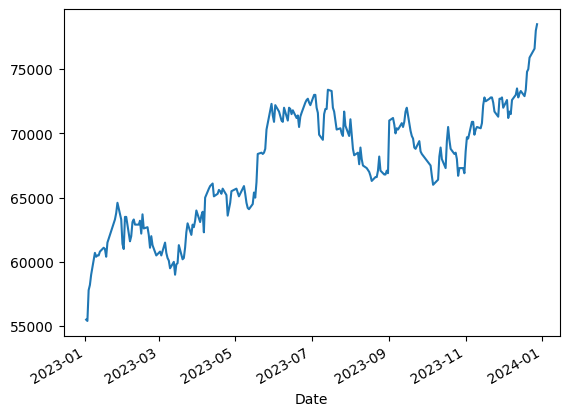

In [ ]:
# 종가 그래프
fig = df['Close'].plot()

In [ ]:
X = df.drop('Close', axis=1) # 정답값열 삭제하여 X에 대입.
y = df[['Close']]

In [ ]:
X.shape

(245, 5)

In [ ]:
from sklearn.preprocessing import StandardScaler

Xss = StandardScaler() # 인풋값을 위한.
yss = StandardScaler() # 정답값을 위한.

X_ss = Xss.fit_transform(X)
y_ss = yss.fit_transform(y)

def seq_data(x, y, sequence_length):

  x_seq = []
  y_seq = []
  for i in range(len(x) - sequence_length):
    x_seq.append(x[i: i+sequence_length])
    y_seq.append(y[i+sequence_length])
                                                                  # 정답을 열벡터로 줘야해서.
  return torch.FloatTensor(x_seq).to(device), torch.FloatTensor(y_seq).view([-1, 1]).to(device) # float형 tensor로 변형, gpu사용가능하게 .to(device)를 사용.

# 200개 데이터를 학습, 나머지를 valid로 사용할 것.
split = 200

# 10일치로 다음날(11일차) 예측
sequence_length = 10

x_seq, y_seq = seq_data(X_ss, y_ss, sequence_length)

x_train_seq = x_seq[:split]
y_train_seq = y_seq[:split]
x_test_seq = x_seq[split:]
y_test_seq = y_seq[split:]
print(x_train_seq.size(), y_train_seq.size())
print(x_test_seq.size(), y_test_seq.size())

torch.Size([200, 10, 5]) torch.Size([200, 1])
torch.Size([35, 10, 5]) torch.Size([35, 1])


In [ ]:
train = TensorDataset(x_train_seq, y_train_seq)
test = TensorDataset(x_test_seq, y_test_seq)

batch_size = 16
train_loader = DataLoader(dataset=train, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(dataset=test, batch_size=batch_size, shuffle=False)

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([16])) that is different to the input size (torch.Size([16, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([8])) that is different to the input size (torch.Size([8, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch [10/100], Loss: 0.1526
Epoch [20/100], Loss: 0.1405
Epoch [30/100], Loss: 0.1347
Epoch [40/100], Loss: 0.1302
Epoch [50/100], Loss: 0.1261
Epoch [60/100], Loss: 0.1230
Epoch [70/100], Loss: 0.1209
Epoch [80/100], Loss: 0.1190
Epoch [90/100], Loss: 0.1171
Epoch [100/100], Loss: 0.1151


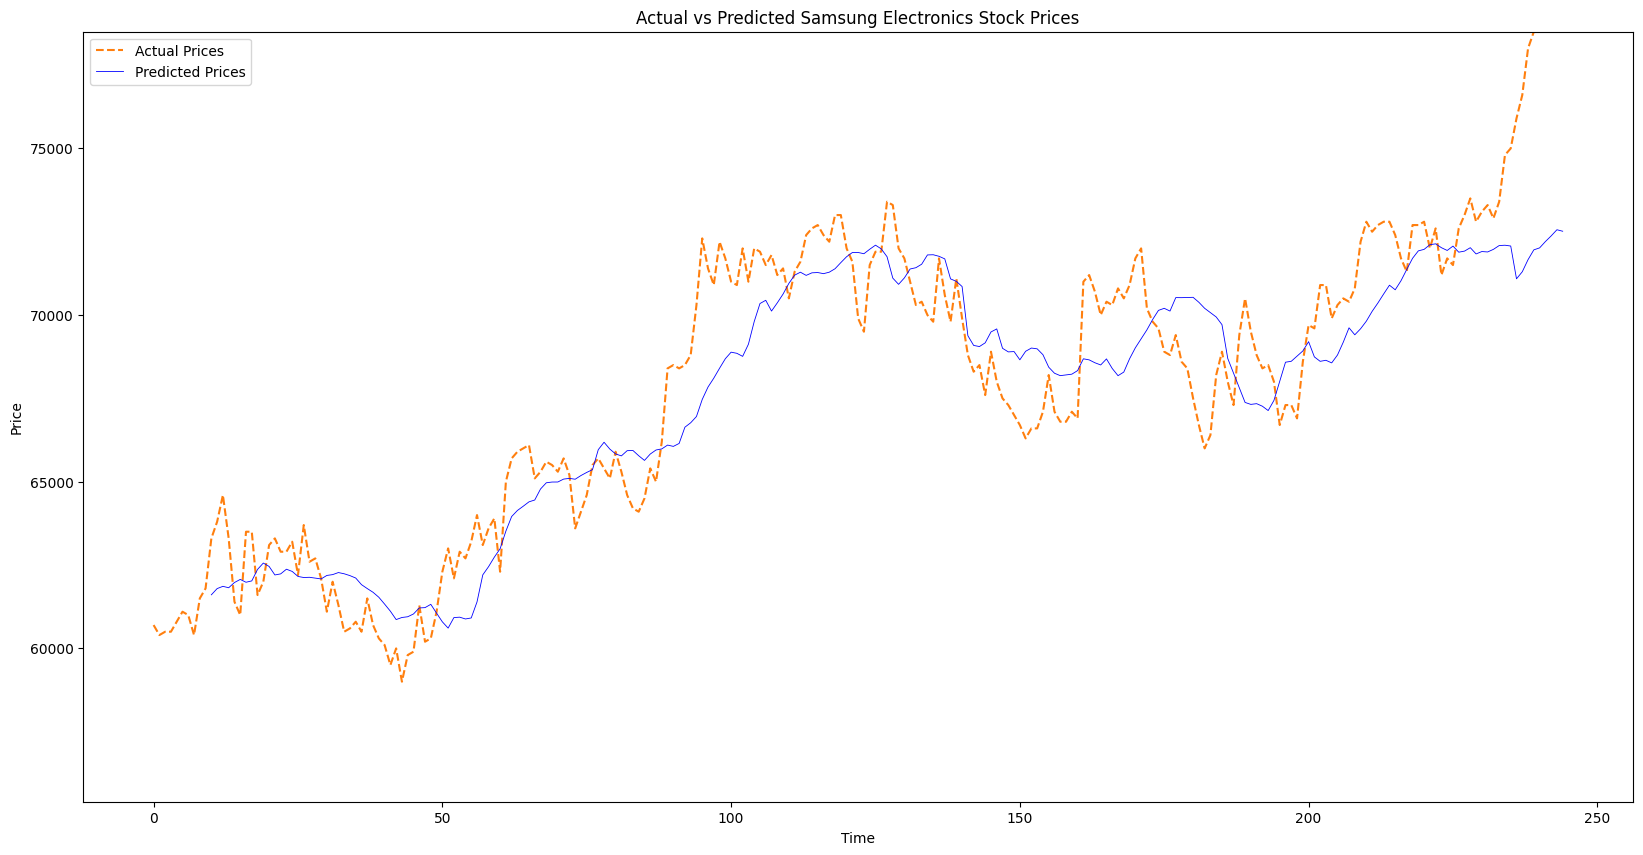

In [ ]:
# GRU 모델 정의
class GRUModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(GRUModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.gru = nn.GRU(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)

        out, _ = self.gru(x, h0)
        out = self.fc(out[:, -1, :])
        return out

input_size = x_train_seq.shape[2]
hidden_size = 16
num_layers = 2
output_size = predict_length

model = GRUModel(input_size, hidden_size, num_layers, output_size).to(device)

# 손실 함수 및 옵티마이저 설정
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# 모델 훈련
num_epochs = 100
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device).squeeze()  # targets의 차원을 줄여줍니다.

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}')

# 예측 수행 및 시각화
model.eval()
with torch.no_grad():
    train_pred = []
    test_pred = []

    for data in train_loader:
        seq, target = data
        out = model(seq.to(device))
        train_pred += out.cpu().numpy().tolist()

    for data in test_loader:
        seq, target = data
        out = model(seq.to(device))
        test_pred += out.cpu().numpy().tolist()

    total = train_pred + test_pred
    total_inverse = yss.inverse_transform(np.array(total).reshape(-1, 1))

    # 전체 실제 주가 시각화
    plt.figure(figsize=(20,10))
    # 학습 데이터 경계선 긋기
    plt.plot(np.ones(100)*len(train_pred), np.linspace(0,1,100), '--', linewidth=0.6)
    # 실제 주가
    plt.plot(df['Close'][seq_length:].values, '--', label='Actual Prices')
    # 예측 주가
    plt.plot(np.arange(len(df) - len(total_inverse), len(df)), total_inverse, 'b', linewidth=0.6, label='Predicted Prices')
    # y축 범위를 종가 최소 최대에 맞춘다.
    plt.ylim(min(df['Close'].values), max(df['Close'].values))
    plt.title('Actual vs Predicted Samsung Electronics Stock Prices')
    plt.legend()
    plt.xlabel('Time')
    plt.ylabel('Price')
    plt.show()


### Transformer로 삼성전자 예측하기

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
Epoch 1/10: 100%|██████████| 99/99 [00:02<00:00, 44.24batch/s, loss=0.00552]


Epoch [1/10], Average Loss: 0.1538


Epoch 2/10: 100%|██████████| 99/99 [00:02<00:00, 36.88batch/s, loss=0.00218]


Epoch [2/10], Average Loss: 0.0054


Epoch 3/10: 100%|██████████| 99/99 [00:02<00:00, 44.84batch/s, loss=0.0015]


Epoch [3/10], Average Loss: 0.0036


Epoch 4/10: 100%|██████████| 99/99 [00:02<00:00, 48.09batch/s, loss=0.00224]


Epoch [4/10], Average Loss: 0.0021


Epoch 5/10: 100%|██████████| 99/99 [00:02<00:00, 47.04batch/s, loss=0.00079]


Epoch [5/10], Average Loss: 0.0018


Epoch 6/10: 100%|██████████| 99/99 [00:02<00:00, 47.37batch/s, loss=0.00152]


Epoch [6/10], Average Loss: 0.0015


Epoch 7/10: 100%|██████████| 99/99 [00:02<00:00, 45.76batch/s, loss=0.00199]


Epoch [7/10], Average Loss: 0.0012


Epoch 8/10: 100%|██████████| 99/99 [00:02<00:00, 36.48batch/s, loss=0.000634]


Epoch [8/10], Average Loss: 0.0010


Epoch 9/10: 100%|██████████| 99/99 [00:02<00:00, 45.25batch/s, loss=0.000896]


Epoch [9/10], Average Loss: 0.0011


Epoch 10/10: 100%|██████████| 99/99 [00:02<00:00, 47.40batch/s, loss=0.000528]


Epoch [10/10], Average Loss: 0.0009


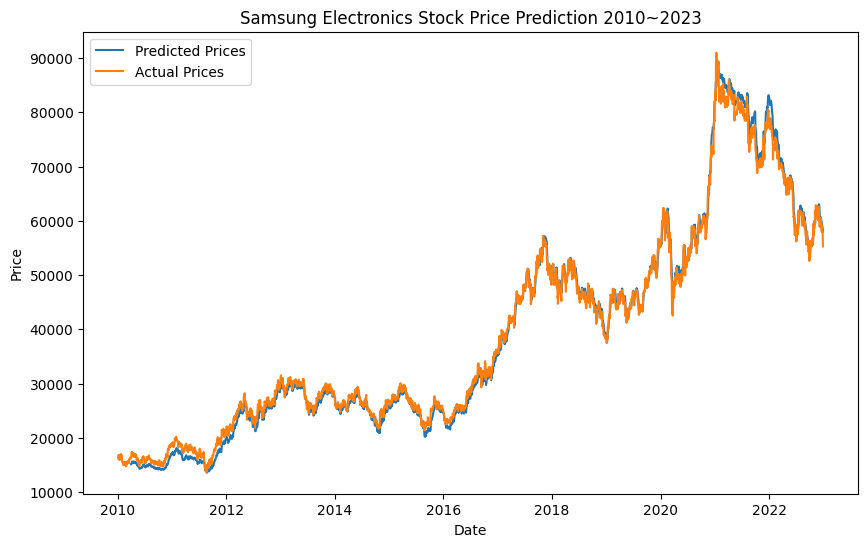

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tqdm import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 삼성전자
ticker = '005930.KS'
data = yf.download(ticker, start="2010-01-01", end="2023-01-01")

# 데이터에서 사용할 피처 (종가, 거래량, 오픈가,  고가, 저가)
data = data[['Close', 'Volume', 'Open', 'High', 'Low']]

# 검증용 데이터 생성 (2023-01-01 ~ 2023-12-31)
valid_data = yf.download(ticker, start="2023-01-01", end="2023-12-31")
valid_data = valid_data[['Close', 'Volume', 'Open', 'High', 'Low']]


# 데이터 정규화
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)
valid_scaled_data = scaler.transform(valid_data)


# 시퀀스 데이터 생성
def create_sequences(data, seq_length):
    xs = []
    ys = []
    for i in range(len(data) - seq_length):
        x = data[i:i + seq_length]
        y = data[i + seq_length][0]  # 종가(Close)를 예측 대상으로 사용
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

seq_length = 60
X, y = create_sequences(scaled_data, seq_length)

X_train = torch.tensor(X, dtype=torch.float32).to(device)
y_train = torch.tensor(y, dtype=torch.float32).to(device)

X_valid, y_valid = create_sequences(valid_scaled_data, seq_length)

X_valid = torch.tensor(X_valid, dtype=torch.float32).to(device)
y_valid = torch.tensor(y_valid, dtype=torch.float32).to(device)

batch_size = 32
train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super(PositionalEncoding, self).__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        # 0부터 max_len-1까지의 정수를 포함하는 1차원 텐서를 생성후 (max_len, 1) 차원으로 만든다.
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-np.log(10000.0) / d_model))
        # 0부터 d_model-1까지의 정수 중 짝수 인덱스만 포함하는 1차원 텐서를 생성
        # 포지셔널 인코딩에서 각 차원의 주파수를 조절하는 스케일링 인자
        pe[:, 0::2] = torch.sin(position * div_term) # 짝수 위치에 사인 함수 값.
        pe[:, 1::2] = torch.cos(position * div_term) # 홀수 위치에 코사인 함수 값.
        pe = pe.unsqueeze(1) # (max_len, d_model) -> (max_len, 1, d_model) 형태로 해서 나중에 x 랑 더할 것임.
                            #  Transformer는 (sequence_length, batch_size, d_model) 형태의 입력을 받기 때문!
        self.register_buffer('pe', pe)

    def forward(self, x):
        return x + self.pe[:x.size(0), :]

class Transformer(nn.Module):
    def __init__(self, input_dim, nhead, num_layers, hidden_dim):
        super(Transformer, self).__init__()
        self.input_fc = nn.Linear(input_dim, hidden_dim)  # 입력 차원을 hidden_dim으로 변환하기 위한 식.
        self.positional_encoding = PositionalEncoding(hidden_dim) # 포지셔널 인코딩 모듈.
        self.transformer = nn.Transformer(
            d_model=hidden_dim,
            nhead=nhead,
            num_encoder_layers=num_layers,
            num_decoder_layers=num_layers
        )
        self.fc = nn.Linear(hidden_dim, 1)

    def forward(self, src):
        src = self.input_fc(src)  # 입력 차원을 hidden_dim으로 반환

        src = self.positional_encoding(src.permute(1, 0, 2))  # src의 차원 순서 (batch_size, seq_len, feature_dim) 이기 때문에.
                                                              # (seq_len, batch_size, feature_dim)로 src의 차원 순서를 바꾸어,
                                                              # 포지셔널 인코딩 적용 (입력의 순서 정보를 추가)
                                                              # 트랜스포머의 인풋 쉐잎이 (seq_len, batch_size, feature_dim) 이기 때문.
        output = self.transformer(src, src) # # Transformer 블록을 통해 시퀀스 데이터를 인코딩하고 디코딩.
        output = self.fc(output[-1])  # 마지막 타임스텝만 사용
        return output

input_dim = X_train.shape[2]  # 피처의 수로 디멘전 설정
nhead = 2
num_layers = 2
hidden_dim = 64  # nhead의 배수로 설정해야함.

model = Transformer(input_dim, nhead, num_layers, hidden_dim).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

num_epochs = 10

# 학습 루프
for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0
    with tqdm(train_loader, unit="batch") as tepoch:
        for batch_X, batch_y in tepoch:
            tepoch.set_description(f"Epoch {epoch + 1}/{num_epochs}")

            optimizer.zero_grad()
            output = model(batch_X)
            loss = criterion(output.squeeze(), batch_y)
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()
            tepoch.set_postfix(loss=loss.item())

    print(f"Epoch [{epoch+1}/{num_epochs}], Average Loss: {epoch_loss / len(train_loader):.4f}")

# 모델 평가 및 예측
model.eval()
with torch.no_grad():
    predictions = model(X_train).squeeze().cpu().numpy()

# 예측값 역정규화                                                #  2차원 배열 전
predicted_prices = scaler.inverse_transform(np.concatenate((predictions.reshape(-1, 1),   # 원래 스케일로 역정규화하려면 입력 데이터와 같은 모양의 데이터가 필요
                                                                      # 예측된 데이터의 수,  #Volume, Open, High, Low 네 가지 피처 (종가는 제외해야 한다) ,
                                                            np.zeros((predictions.shape[0], scaled_data.shape[1] - 1))), axis=1))[:, 0]
                                                            # np.concatenate를 사용하여 predictions와 0으로 채운 배열을 함께 합치고 0 번째 컬럼만 가져옴

# 시각화
plt.figure(figsize=(10, 6))
plt.plot(data.index[seq_length:], predicted_prices, label='Predicted Prices')
plt.plot(data.index, data['Close'], label='Actual Prices')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.title('Samsung Electronics Stock Price Prediction 2010~2023')
plt.show()


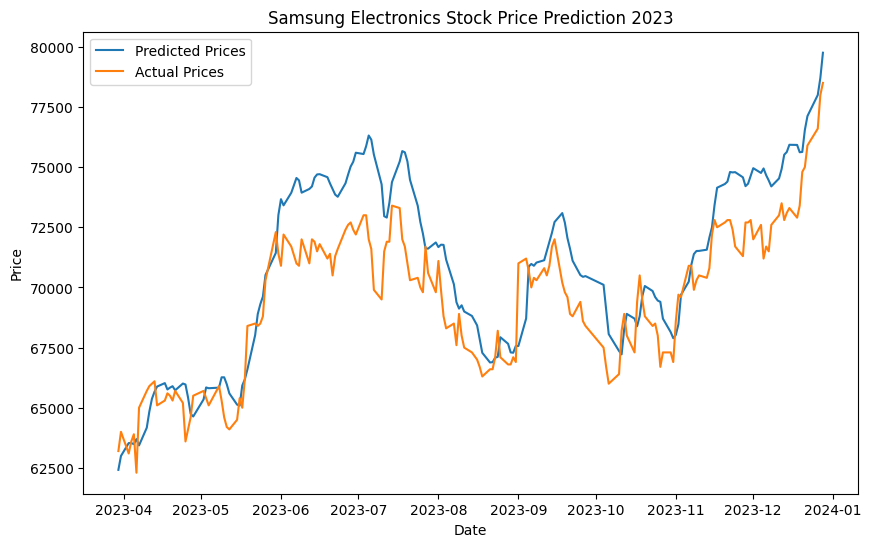

In [ ]:
# 모델 평가 및 예측 (검증 데이터 사용)
model.eval()
with torch.no_grad():
    valid_predictions = model(X_valid).squeeze().cpu().numpy()

# 예측값 역정규화
valid_predicted_prices = scaler.inverse_transform(np.concatenate((valid_predictions.reshape(-1, 1),
                                                                  np.zeros((valid_predictions.shape[0], valid_scaled_data.shape[1] - 1))), axis=1))[:, 0]
# 시각화 (2023년 데이터)
plt.figure(figsize=(10, 6))
plt.plot(valid_data.index[seq_length:], valid_predicted_prices, label='Predicted Prices')
plt.plot(valid_data.index[seq_length:], valid_data['Close'][seq_length:], label='Actual Prices')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.title('Samsung Electronics Stock Price Prediction 2023')
plt.show()
